<a href="https://colab.research.google.com/github/cobridi/detecao-anomalias-emissoes/blob/main/dete%C3%A7%C3%A3o_anomalia_emissoes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introdução

Este Notebook faz parte do trabalho final do curso BI MASTER Turma 2019.03 do aluno Claudio Bridi, orientado pela Prof. Evelyn.

# Objetivo: 

Criar um algoritmo para detectar anomalias em série temporal de emissões mensais de CO2-equivalente das fontes de uma UEP (Unidade Estacionária de Produção de Óleo e Gás), no período de 2015 a 2019.

# Material
- Google Colaboratory
- Planilha de dados brutos contendo "nome da instalação", "tipo de fonte", "código da fonte", "Ano", "Mês", "CO2 emitido", em formatos csv e excel
- Git Hub
- Arquivo com código em python da disciplina CONF: deteçãodeanomaliasemseries.ipynb

# Aplicabilidade:
Este algoritmo poderá ser utilizado na industria de óleo e gás, mais especificamente, e também para empresas que precisem registrar, inventariar, divulgar e trabalhar com dados de emissões de gases de efeito estufa. Para detecção e correção das anomalias em dados, na maioria das vezes inseridos manualmente em sistema ou planilha específica, também costumamente são verificados no olho por algum profissional todos o anos, antes de comporem as informações do inventário e relatório de emissões, divulgado tanto internamente quanto para stakeholders externos. Isto é, por serem muitos dados e de muitas fontes, anomalias podem passar despercebidas, prejudicando a análise de dados, atendimento de compromissos assumidos e perda de credibilidade.

# Orientação:
Esta ideia surgiu na disciplina de Confiabilidade quando estudamos a detecção de anomalias em séries temporais de dados de precipitação em NY. Pensei em como ponto de partida utilizar o mesmo algorítimo e avançar a partir de então. #

# Prazo:
Finalizado no GitHub até 30/12/2020.


# Detecção de anomalias em Séries Temporais de Emissões de Gases de Efeito Estufa por equipamentos de uma plataforma de petróleo

### Planejamento por etapas:

*  Carregar, preparar e analisar dados
*  Pré-Processar os dados
*  Controle estatístico do processo (CEP) para detectar anomalias*
*  Modelos Autorregressivos
*  Avaliação dos modelos
*  Conclusão Final









## Importando



In [3]:
%matplotlib inline
#import warnings
#warnings.filterwarnings('ignore', category=FutureWarning)
import sys
import datetime as dt
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import random
import seaborn as sns
from scipy import stats
import statsmodels as ss
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA
from datetime import datetime
from dateutil.parser import parse

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Python and library versions

In [72]:
packages = [matplotlib, np, pd]

msg = f"""
Python Version: {sys.version}

library .      version
-------        -------"""
print(msg)

for package in packages:
    print(f"{package.__name__:11}    {package.__version__:>7}")


Python Version: 3.6.9 (default, Oct  8 2020, 12:12:24) 
[GCC 8.4.0]

library .      version
-------        -------
matplotlib       3.2.2
numpy           1.19.4
pandas           1.1.5


# Seção 1: Carregar, Preparar e Analisar os dados

In [73]:
df_emissions = pd.read_excel('Platco2e2015_2019.xlsx', header=7)
df_emissions.head()

,07 - Instalação,11 - Tipo de Fonte,14 - Fonte Emissora,21 - Ano civil,20 - Mês/Ano,CO2e - AR4 (Mg)
0,FPSO Plat A,MEA/DEA,T-Z-1235001,2015,ABR 2015,2279.143017
1,FPSO Plat A,MEA/DEA,T-Z-1235001,2015,AGO 2015,8298.613180
2,FPSO Plat A,MEA/DEA,T-Z-1235001,2015,DEZ 2015,6083.260307
3,FPSO Plat A,MEA/DEA,T-Z-1235001,2015,FEV 2015,4703.897479
4,FPSO Plat A,MEA/DEA,T-Z-1235001,2015,JAN 2015,5695.723917


Queremos duas coisas: Ter uma nova coluna que indique o ano e mês do registro de emissão (2019-10, por exemplo), para que a série de dados fique na sequência. Posteriormente vamos separar os dataframes por tipo de fonte, para que cada fonte seja uma série de dados.

In [74]:
df_emissions['11 - Tipo de Fonte'].value_counts()

Turbina                      460
Motor                        213
Tocha                        170
Equipamento de Construção    114
MEA/DEA                       60
Desidratador a Glicol         60
Fugitiva                      59
Armazenamento de Petróleo     36
Name: 11 - Tipo de Fonte, dtype: int64

In [78]:
df_emissions['11 - Tipo de Fonte'].describe()

count        1172
unique          8
top       Turbina
freq          460
Name: 11 - Tipo de Fonte, dtype: object

In [79]:
df_emissions['14 - Fonte Emissora'].value_counts()

T-Z-1235001                  60
GE-5147001C                  60
T-Z-1227001-01               60
GE-5147001 B                 60
GE-5147001 D                 60
GE-5147001A                  60
GD-5266001 B                 57
GE-5147001 B Diesel          57
GD-5266001 A                 57
GE-5147001A Diesel           56
FUGITIVAS GÁS                55
MC-B-UB-5420001 A            55
MC-B-UB-5420001 B            55
GE-5147001D Diesel           54
GE-5147001 D Diesel          53
MC-GE-5261001                52
MC-GE-5262001                51
TOCHA HP/LP                  50
QUEIMA DE PURGA              50
QUEIMA PILOTO                50
TQ PETRÓLEO Plat A           36
TA-5412001 LP                10
TA-5412001 HP                10
FUGITIVAS PADROES MEDIDAS     4
Name: 14 - Fonte Emissora, dtype: int64

In [80]:
df_emissions['14 - Fonte Emissora'].describe()

count            1172
unique             24
top       T-Z-1235001
freq               60
Name: 14 - Fonte Emissora, dtype: object

Como visto na análise acima, a coluna '14 - Fonte Emissora' conta com 24 tipo de fontes. Já a coluna '11 - Tipo de Fonte' conta com 8 tipos. Minha ideia preliminar era realizar a análise de anomalia por Tipo de Fonte, no entanto vi que o mesmo tipo de fonte conta com mais de uma fonte emissora e os dados variam muito. Portanto a Análise deverá ser realizada po Fonte Emissora.

In [81]:
df_emissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1172 entries, 0 to 1171
Data columns (total 6 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   07 - Instalação      1172 non-null   object 
 1   11 - Tipo de Fonte   1172 non-null   object 
 2   14 - Fonte Emissora  1172 non-null   object 
 3   21 - Ano civil       1172 non-null   int64  
 4   20 - Mês/Ano         1172 non-null   object 
 5   CO2e - AR4 (Mg)      1172 non-null   float64
dtypes: float64(1), int64(1), object(4)
memory usage: 55.1+ KB


Vamos dividir a coluna "20 - Mês/Ano" e pegar só o valor do mês para uma nova coluna:

In [82]:
divisao = df_emissions['20 - Mês/Ano'].str.split(' ')

In [83]:
divisao.head()

0    [ABR, 2015]
1    [AGO, 2015]
2    [DEZ, 2015]
3    [FEV, 2015]
4    [JAN, 2015]
Name: 20 - Mês/Ano, dtype: object

In [84]:
mes = divisao.str.get(0)

In [85]:
df_emissions['Mês'] = mes

In [86]:
df_emissions.head()

,07 - Instalação,11 - Tipo de Fonte,14 - Fonte Emissora,21 - Ano civil,20 - Mês/Ano,CO2e - AR4 (Mg),Mês
0,FPSO Plat A,MEA/DEA,T-Z-1235001,2015,ABR 2015,2279.143017,ABR
1,FPSO Plat A,MEA/DEA,T-Z-1235001,2015,AGO 2015,8298.613180,AGO
2,FPSO Plat A,MEA/DEA,T-Z-1235001,2015,DEZ 2015,6083.260307,DEZ
3,FPSO Plat A,MEA/DEA,T-Z-1235001,2015,FEV 2015,4703.897479,FEV
4,FPSO Plat A,MEA/DEA,T-Z-1235001,2015,JAN 2015,5695.723917,JAN


Agora, vamos substituir os meses do formato com letras para números inteiros:

In [87]:
df_emissions['Mês'].replace({'JAN':"01", "FEV":"02", 'MAR':'03', 'ABR':'04', 'MAI':'05', 'JUN':'06', 'JUL':'07', 'AGO':'08', 'SET':'09', 'OUT':'10', 'NOV':'11', 'DEZ':'12'}, inplace=True)

In [88]:
df_emissions.head()

,07 - Instalação,11 - Tipo de Fonte,14 - Fonte Emissora,21 - Ano civil,20 - Mês/Ano,CO2e - AR4 (Mg),Mês
0,FPSO Plat A,MEA/DEA,T-Z-1235001,2015,ABR 2015,2279.143017,04
1,FPSO Plat A,MEA/DEA,T-Z-1235001,2015,AGO 2015,8298.613180,08
2,FPSO Plat A,MEA/DEA,T-Z-1235001,2015,DEZ 2015,6083.260307,12
3,FPSO Plat A,MEA/DEA,T-Z-1235001,2015,FEV 2015,4703.897479,02
4,FPSO Plat A,MEA/DEA,T-Z-1235001,2015,JAN 2015,5695.723917,01


Vamos juntar em uma só coluna o ano e mês em formato "numérico"

In [89]:
df_emissions['Ano-Mes'] = df_emissions['21 - Ano civil'].astype(str).add('-') + df_emissions['Mês']

In [90]:
df_emissions.head()

,07 - Instalação,11 - Tipo de Fonte,14 - Fonte Emissora,21 - Ano civil,20 - Mês/Ano,CO2e - AR4 (Mg),Mês,Ano-Mes
0,FPSO Plat A,MEA/DEA,T-Z-1235001,2015,ABR 2015,2279.143017,04,2015-04
1,FPSO Plat A,MEA/DEA,T-Z-1235001,2015,AGO 2015,8298.613180,08,2015-08
2,FPSO Plat A,MEA/DEA,T-Z-1235001,2015,DEZ 2015,6083.260307,12,2015-12
3,FPSO Plat A,MEA/DEA,T-Z-1235001,2015,FEV 2015,4703.897479,02,2015-02
4,FPSO Plat A,MEA/DEA,T-Z-1235001,2015,JAN 2015,5695.723917,01,2015-01


In [91]:
df_emissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1172 entries, 0 to 1171
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   07 - Instalação      1172 non-null   object 
 1   11 - Tipo de Fonte   1172 non-null   object 
 2   14 - Fonte Emissora  1172 non-null   object 
 3   21 - Ano civil       1172 non-null   int64  
 4   20 - Mês/Ano         1172 non-null   object 
 5   CO2e - AR4 (Mg)      1172 non-null   float64
 6   Mês                  1172 non-null   object 
 7   Ano-Mes              1172 non-null   object 
dtypes: float64(1), int64(1), object(6)
memory usage: 73.4+ KB


###Como a data está em formato de série, tenho que convertê-la para date:

In [92]:
type(df_emissions['Ano-Mes'])

pandas.core.series.Series

In [93]:
df_emissions['Ano-Mes'] = pd.to_datetime(df_emissions['Ano-Mes'])

In [94]:
df_emissions.head()

,07 - Instalação,11 - Tipo de Fonte,14 - Fonte Emissora,21 - Ano civil,20 - Mês/Ano,CO2e - AR4 (Mg),Mês,Ano-Mes
0,FPSO Plat A,MEA/DEA,T-Z-1235001,2015,ABR 2015,2279.143017,04,2015-04-01
1,FPSO Plat A,MEA/DEA,T-Z-1235001,2015,AGO 2015,8298.613180,08,2015-08-01
2,FPSO Plat A,MEA/DEA,T-Z-1235001,2015,DEZ 2015,6083.260307,12,2015-12-01
3,FPSO Plat A,MEA/DEA,T-Z-1235001,2015,FEV 2015,4703.897479,02,2015-02-01
4,FPSO Plat A,MEA/DEA,T-Z-1235001,2015,JAN 2015,5695.723917,01,2015-01-01


In [95]:
df_emissions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1172 entries, 0 to 1171
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   07 - Instalação      1172 non-null   object        
 1   11 - Tipo de Fonte   1172 non-null   object        
 2   14 - Fonte Emissora  1172 non-null   object        
 3   21 - Ano civil       1172 non-null   int64         
 4   20 - Mês/Ano         1172 non-null   object        
 5   CO2e - AR4 (Mg)      1172 non-null   float64       
 6   Mês                  1172 non-null   object        
 7   Ano-Mes              1172 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1), int64(1), object(5)
memory usage: 73.4+ KB


Agora, vamos criar um novo dataframe com a primeira Fonte Emissora que vamos analisar.

In [96]:
df_fonte1= df_emissions.loc[df_emissions['14 - Fonte Emissora']=='T-Z-1235001']

In [97]:
df_fonte1.head()

,07 - Instalação,11 - Tipo de Fonte,14 - Fonte Emissora,21 - Ano civil,20 - Mês/Ano,CO2e - AR4 (Mg),Mês,Ano-Mes
0,FPSO Plat A,MEA/DEA,T-Z-1235001,2015,ABR 2015,2279.143017,04,2015-04-01
1,FPSO Plat A,MEA/DEA,T-Z-1235001,2015,AGO 2015,8298.613180,08,2015-08-01
2,FPSO Plat A,MEA/DEA,T-Z-1235001,2015,DEZ 2015,6083.260307,12,2015-12-01
3,FPSO Plat A,MEA/DEA,T-Z-1235001,2015,FEV 2015,4703.897479,02,2015-02-01
4,FPSO Plat A,MEA/DEA,T-Z-1235001,2015,JAN 2015,5695.723917,01,2015-01-01


Colocando os dados em ordem crescente de data:

In [124]:
df_fonte1 = df_fonte1.sort_values('Ano-Mes')

In [125]:
df_fonte1_ = pd.DataFrame(df_fonte1, columns=['Ano-Mes','CO2e - AR4 (Mg)'])

In [126]:
df_fonte1_.head()

,Ano-Mes,CO2e - AR4 (Mg)
4,2015-01-01,5695.723917
3,2015-02-01,4703.897479
8,2015-03-01,3148.262873
0,2015-04-01,2279.143017
7,2015-05-01,3696.974132


In [128]:
newdf_fonte1 = pd.read_csv('fonte1.csv', parse_dates=True, index_col=0)

In [129]:
newdf_fonte1.head()

,CO2e - AR4 (Mg)
Ano-Mes,
2015-01-01,5695.723917
2015-02-01,4703.897479
2015-03-01,3148.262873
2015-04-01,2279.143017
2015-05-01,3696.974132


In [130]:
newdf_fonte1['CO2e - AR4 (Mg)'].describe()

count       60.000000
mean      8008.698108
std       2009.786665
min       2279.143017
25%       7134.415966
50%       8382.004994
75%       9687.160768
max      10384.143120
Name: CO2e - AR4 (Mg), dtype: float64

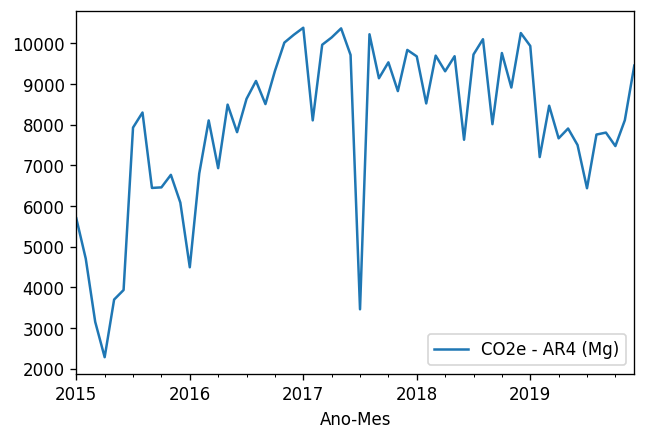

In [133]:
plt.figure(dpi=120)
newdf_fonte1.plot(ax=plt.gca())
plt.show();

Pela descrição dos dados bem como pelo gráfico plotado, é possível observar que os dados da fonte emissora 'T-Z-1235001' variam de 2279.143017 a 10384.143120, com média de 8008.698108 e desvio padrão de 2009.786665. Com os dados desta forma, não parece haver alguma anomalia bem como também parece ser muito difícil detectar caso haja.

# Gráfico de Controle

Pelas estatísticas resumidas e no gráfico provavelmente as anomalias estarão abaixo da média, que é de 8008.698108; portanto, precisamos apenas de um gráfico de controle unilateral. (Preciso descobrir um gráfico que veja acima e abaixo)

Como os dados de emissões não podem ser um número negativo, quase todos os valores possíveis acima da média estão no intervalo 8008.698108 <= emissão <= 10384.143120), Que estão quase todos dentro de um desvio padrão (2009.786665) Da média e, portanto, provavelmente não sejam anomalias (mas como dito acima, preciso de um gráfico que pegue acima e abaixo)

Portanto, vamos criar um gráfico de controle unilateral (para baixo que era o único exemplo que tinha)

In [134]:
def control_plot(time_series, threshold):
    '''
    Creates a one-sided control plot from a time series
    (that is, plots threshold above the mean but not below)
    Also, returns list of points that exceed the threshold
    i.e., points for which the value > mean + threshold*(standard deviation)
    
    Args: 
        time_series: (pandas dataframe; index column is date in datetime format and  
        column 0 is data)
        threshold: z-score threshold for anomaly detection (float)

    Returns: 
        Control plot of time_series    
        anomalies: anomalies that exceed threshold (pandas dataframe)
    ''' 
    
    mean_= time_series.iloc[:,0].mean()
    stdev_= time_series.iloc[:,0].std()
    cutoff = mean_+threshold*stdev_
    plt.figure(dpi=140)
    time_series.plot(ax=plt.gca())
    plt.axhline(y=mean_, color='g', linestyle='--', label='mean')
    # Use threshold to plot line at threshold*stdev_ times away from the mean
    plt.axhline(y=cutoff, color='r', linestyle=':', label='threshold')
    plt.legend(loc='best')
    plt.title('Fonte1')
    plt.ylabel('Emissões CO2eq')
    
    # Create dataframe of anomalies that exceed the cutoff
    anomalies = time_series[time_series.values > cutoff]
    return anomalies

Defina um limite de 3 desvios padrão e plote os resultados.

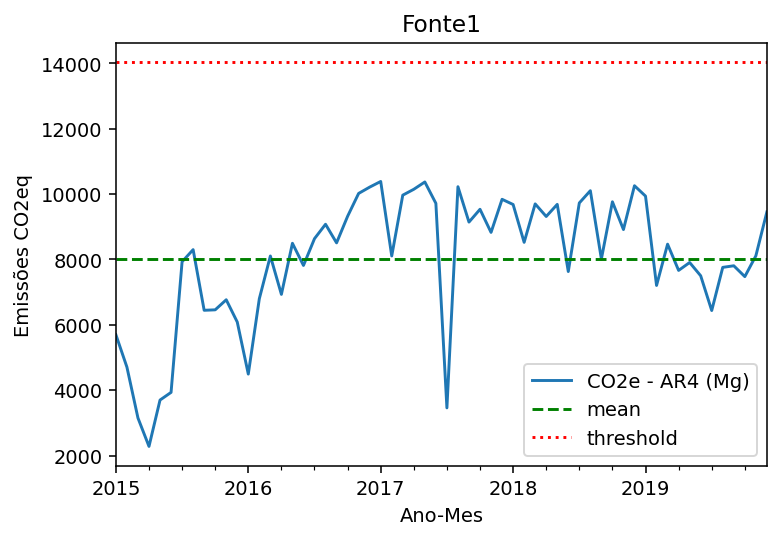

In [138]:
anomaly_fonte1 = control_plot(newdf_fonte1, 3)

Pelo gráfico gerado, não foi detectada nenhuma anomalia na Fonte 1 = T-Z-1235001. No entanto, como já indicado o mais provável é que a anomalia estivesse abaixo da média e não acima. Aqui que eu precisaria de uma ajudinha do orientador.

In [139]:
print(anomaly_fonte1)

Empty DataFrame
Columns: [CO2e - AR4 (Mg)]
Index: []


# Soma acumulada (CUSUM)

In [207]:
def cusum(data, mean, shift, threshold):
    '''
   as somas cumulativas alta e baixa e use-as para detecção de anomalias.
     Uma anomalia é relatada se as somas cumulativas estiverem além de um determinado limite.
    
     Args:
         data: (uma série temporal como pandas dataframe; a coluna do índice é a data no formato datetime e
         coluna 0 são dados)
         mean: média dos dados ou outra média (flutuante)
         mudança: mudança normal nos dados; o desvio padrão é recomendado (flutuante)
         threshold: limite para classificar o ponto como anomalia (float)

     Devoluções:
         cusum: as somas cumulativas alta e baixa juntas Calcular com os dados (pandas dataframe)
         anomalias: anomalias acima e abaixo do limite (pandas dataframe)
    ''' 
    high_sum = 0.0
    low_sum = 0.0
    anomalies = [] 
    high_sum_final = []
    low_sum_final = []
    index_names = data.index
    data_values = data.values
    for index, item in enumerate(data_values):
        high_sum = max(0, high_sum + item - mean - shift)
        low_sum = min(0, low_sum + item - mean + shift)
        high_sum_final.append(high_sum)
        low_sum_final.append(low_sum)
        if high_sum > threshold or low_sum < -threshold:
            anomalies.append((index_names[index], item.tolist()))
    cusum = data
    cusum = cusum.assign(High_Cusum=high_sum_final, Low_Cusum=low_sum_final)
    return cusum, anomalies

In [208]:
def cusum_plot(time_series, threshold):
    '''
    Plote as somas cumulativas alta e baixa e use-as para detecção de anomalias.
     Uma anomalia é relatada se as somas cumulativas estiverem além de um determinado limite.
    
     Args:
         time_series: (uma série temporal como pandas dataframe; a coluna de índice é date
         no formato datetime e a coluna 0 é data)
         threshold: limite para classificar o ponto como anomalia (float)

     Devoluções:
         Uma plotagem dos dados com a soma acumulada alta.
         cusum_results: as somas cumulativas alta e baixa, juntamente com dados
         e quaisquer anomalias acima e abaixo do limite (quadro de dados do pandas;
         da função cumsum)
    ''' 
    # Use a média e o desvio padrão de toda a série temporal
     # para calcular somas cumulativas
    mean_= time_series.iloc[:,0].mean()
    stdev_= time_series.iloc[:,0].std()
    
    # definir limiar em termos de desvio padrão
    cusum_results = cusum(time_series, mean_, stdev_, threshold*stdev_)
    ax=time_series.plot()
    ax.axhline(y=mean_, color='g', linestyle='--',label='average')
    ax.axhline(y=mean_+threshold*stdev_, color='r', linestyle='--',label='High threshold')
    ax.axhline(y=mean_-threshold*stdev_, color='r', linestyle='--',label='Low threshold')
    # Use threshold to plot line at threshold*stdev_ times away from the mean
    ax.scatter(x=cusum_results[0].index, y=cusum_results[0]['Low_Cusum'], 
             color='k', linestyle=':',label='Low Cusum')                      
    plt.legend(loc='lower right')
    plt.title('Fonte 1 Emissions - CUSUM')
    plt.ylabel('CO2 Emissions')
    plt.gcf().set_size_inches(8,6)
    plt.show()
    return cusum_results

Escolha do limiar: para o gráfico de controle, usamos 3 vezes o desvio padrão. Observe que o limite equivalente para CUSUM é * threshold * = 2, pois CUSUM inclui o * shift * (que escolhemos ser um desvio padrão) em seu cálculo da soma acumulada.

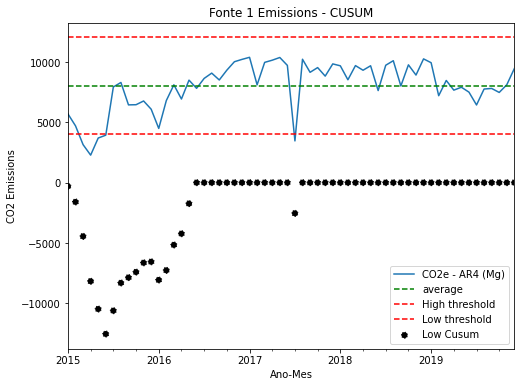

In [213]:
anomaly_fonte1_cusum = cusum_plot(newdf_fonte1, 2);

Observe que CUSUM encontra a mesma anomalia que a carta de controle (1,03 polegadas em 11 de outubro de 2018), mas também rotula os dois pontos sucessivos como anomalias. Por quê?

Os diferentes resultados refletem a diferença nos algoritmos. A tabela de controle está procurando pontos únicos e anômalos. CUSUM é sensível a alterações no comportamento dos dados. Como resultado, sinaliza pontos como anômalos até que o comportamento da série temporal retorne ao normal.

De fato, CUSUM é usado para detecção de pontos de mudança: encontrar quando a distribuição subjacente da série temporal mudou.

In [214]:
print(anomaly_fonte1_cusum)

(            CO2e - AR4 (Mg)            High_Cusum              Low_Cusum
Ano-Mes                                                                 
2015-01-01      5695.723917                     0  [-303.18752580144564]
2015-02-01      4703.897479                     0  [-1598.2014901506423]
2015-03-01      3148.262873                     0   [-4448.850060299788]
2015-04-01      2279.143017                     0   [-8168.618486379235]
2015-05-01      3696.974132                     0   [-10470.55579717368]
2015-06-01      3931.645483                     0  [-12537.821757577376]
2015-07-01      7928.078435                     0  [-10608.654765441772]
2015-08-01      8298.613180                     0   [-8308.953028901667]
2015-09-01      6443.080507                     0   [-7864.783965568113]
2015-10-01      6457.028056                     0  [-7406.6673526263585]
2015-11-01      6765.102026                     0   [-6640.476769327854]
2015-12-01      6083.260307                     0 

Não consegui imprimir os dados que apresentaram apenas anomalias. No gráfico da aula o professo também só teve o dado visual. Outra dificuldade não solucionada foi na plotagem do CUSUM em cima do gráfico de emissões.

# Seção 2: modelos autogressivos

Nos dois métodos anteriores, realizamos a análise no modo offline - tínhamos todos os dados de interesse em mãos. Como resultado, ao examinar um determinado ponto, poderíamos usar o passado e o futuro (com relação a esse ponto) para calcular estatísticas como a média e o desvio padrão.

Modelos autoregressivos são comumente usados para detecção de anomalias em fluxo. Para analisar séries temporais no modo de streaming - ou seja, à medida que os dados se tornam disponíveis.

Como linha de base para o modelo de regressão automática, podemos verificar o que um gráfico de controle revela como anomalias. Em contraste com o exemplo da precipitação, aqui podemos ter anomalias em ambos os lados da média, portanto modificamos * control_plot * para se tornar um gráfico de controle completo de dois lados.

In [215]:
def control_plot_full(time_series, threshold):
    '''
    Cria um gráfico de controle frente e verso de uma série temporal
     (limiar de plotagem acima e abaixo da média)
     Além disso, retorna a lista de pontos que excedem o limite
     ou seja, pontos para os quais o valor> média + limite * (desvio padrão)
     e valor <média - limiar * (desvio padrão)
    
     Args:
         time_series: (pandas dataframe; a coluna de índice é a data no formato datetime e
         coluna 0 são dados)
         threshold: limite para detecção de anomalias (float)

     Devoluções:
         Gráfico de controle de time_series
         anomalias: anomalias que excedem o limite (pandas dataframe)
    ''' 
    
    mean_= time_series.iloc[:, 0].mean()
    stdev_= time_series.iloc[:, 0].std()
    time_series.plot()
    plt.axhline(y=mean_, color='g', linestyle='--',label='average')
    # Use threshold to plot line at threshold*stdev_ times away from the mean
    plt.axhline(y=mean_+threshold*stdev_, color='r', linestyle=':', label='high threshold')
    plt.axhline(y=mean_-threshold*stdev_, color='m', linestyle=':', label='low threshold')
    plt.legend(loc='upper right')
    plt.title('Fonte 1 Emissions')
    plt.ylabel('CO2eq Emissions')
    plt.gcf().set_size_inches(8,6)
    plt.show()
    
    # Create dataframe of anomalies that exceed the threshold
    anomaly_mask = (np.abs(time_series.values - mean_) > threshold*stdev_)
    anomalies = time_series[anomaly_mask]
    return anomalies

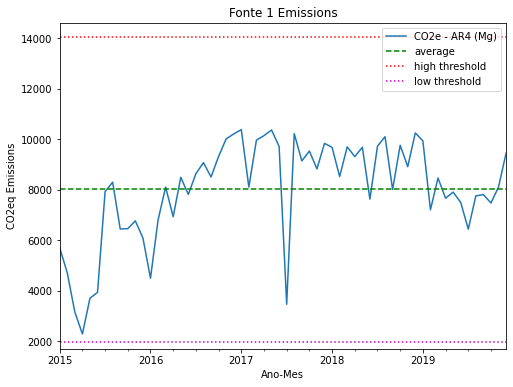

,CO2e - AR4 (Mg)
Ano-Mes,


In [216]:
control_plot_full(newdf_fonte1, 3)

Somente pelo resultado do gráfico não encontramos nenhuma anomalia.

In [217]:
print(newdf_fonte1.index.inferred_freq)

MS


Frequência mensal

In [218]:
newdf_fonte1.index.freq=newdf_fonte1.index.inferred_freq

In [219]:
efonte1_sar=ARIMA(newdf_fonte1, order=(1,1,4)).fit()

efonte1_sar.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:      D.CO2e - AR4 (Mg)   No. Observations:                   59
Model:                 ARIMA(1, 1, 4)   Log Likelihood                -513.581
Method:                       css-mle   S.D. of innovations           1446.109
Date:                Sun, 20 Dec 2020   AIC                           1041.161
Time:                        18:02:57   BIC                           1055.704
Sample:                    02-01-2015   HQIC                          1046.838
                         - 12-01-2019                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
const                      63.2694     59.587      1.062      0.293     -53.519     180.058
ar.L1.D.CO2e - AR4 (Mg)    -0.8309      0.197     -4.208      0.000      -1.218      -0.444
ma.L1.D.CO2e - AR4 (Mg)     0.2987      0.238      1.254      0.215      -0.168       0.765
ma.L2.D.CO2e - AR4 (Mg)    -0.5959      0.170     -3.496      0.001      -0.930      -0.262
ma.L3.D.CO2e - AR4 (Mg)    -0.0585      0.152     -0.384      0.702      -0.357       0.240
ma.L4.D.CO2e - AR4 (Mg)    -0.0978      0.139     -0.704      0.485      -0.370       0.175
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1           -1.2036           +0.0000j            1.2036            0.5000
MA.1           -1.0379           -0.0000j            1.0379           -0.5000
MA.2            1.2888           -0.0000j            1.2888           -0.0000
MA.3           -0.4248           -2.7320j            2.7648           -0.2745
MA.4           -0.4248           +2.7320j            2.7648            0.2745
-----------------------------------------------------------------------------
"""

Como no exemplo de aula, não discutiremos as estatísticas relatadas, exceto para dizer que ela inclui o desvio padrão dos resíduos (59.587	), que usaremos posteriormente.

Verificamos os diagnósticos para verificar se as premissas subjacentes ao modelo são atendidas e também para obter informações adicionais sobre a qualidade do ajuste. Isso é feito usando um gráfico Q-Q (verificando se os resíduos seguem uma distribuição normal), investigando os resíduos por padrões temporais e plotando um histograma dos resíduos

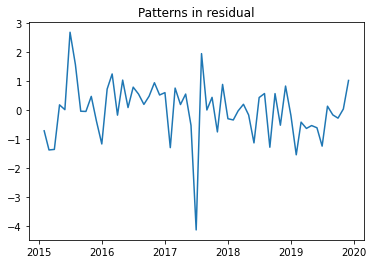

In [221]:
# Get the predicted standard deviation. This is the 6.516 we saw earlier
sigma_pred = efonte1_sar.resid.std()
# Calculate the standardized residuals from the (regular) residuals
efonte1_std_resid = efonte1_sar.resid/sigma_pred

plt.title('Patterns in residual')
plt.plot(efonte1_std_resid);

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


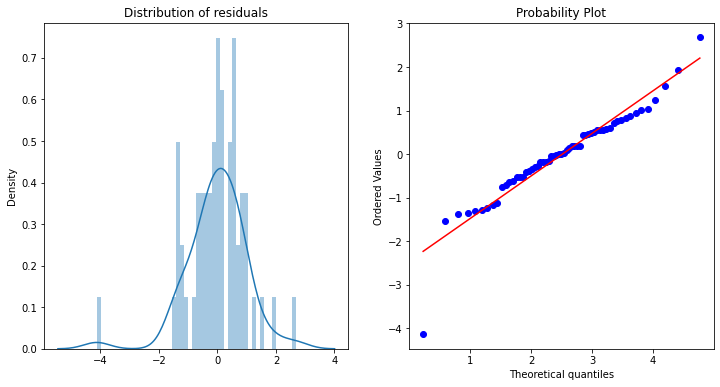

In [222]:
fig = plt.figure(figsize=(12,6))
ax = plt.subplot(121)
plt.title('Distribution of residuals')
sns.distplot(efonte1_std_resid.values, bins=50, ax=ax);
stats.probplot(efonte1_std_resid.values, dist='norm', sparams=(2.5,), plot=plt.subplot(122));

Para detecção de anomalias, focamos no gráfico superior: resíduos padronizados. O residual padronizado é o residual (a diferença entre o valor observado e o valor previsto) dividido pelo desvio padrão previsto (a raiz quadrada da variação prevista mencionada acima). É uma versão mais sofisticada do z-score que discutimos na 1 aula.

Uma regra prática para detectar anomalias com resíduos padronizados: anomalias são pontos para os quais a magnitude dos resíduos padronizados é maior que 4. Vamos encontrar esses pontos.

In [223]:
# Reportar as anomalias
anomaly_mask = np.abs(tmax_std_resid) > 4
efonte1_anomalies = efonte1_std_resid[anomaly_mask]
print(efonte1_anomalies)

Ano-Mes
2017-07-01   -4.127769
Freq: MS, dtype: float64


Nosso modelo encontrou como anomalia o dado de 2017-07-01.

O próximo passo seria variar os parâmetros do modelo de autorregressão e verificar a robustez dessas descobertas, mas como isso pertence ao reino da análise de série temporal, vamos parar por aqui.

# Aplicar a auto regressão para uma outra fonte

# Alterar os dados de uma fonte para ver se o modelo pega.